<a href="https://colab.research.google.com/github/srinilsukumar/Data-analysis-ML-Projects/blob/main/Computer_vision_image_classification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT REQUIRED TORCH LIBRARIES**

In [1]:
import sys
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

In [2]:
'''
SEEDING FOR GETTING SAME OUTPUT
'''

torch.manual_seed(42)

In [3]:
'''
LOAD MNIST DATASET
'''

data_path = '/content/drive/MyDrive/data'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
full_train_set = dset.MNIST(root=data_path, train=True, transform=trans, download=True)
full_test_set = dset.MNIST(root=data_path, train=False, transform=trans)
batch_size = 16

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 916826.69it/s] 


Extracting /content/drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 137331.00it/s]


Extracting /content/drive/MyDrive/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276888.54it/s]


Extracting /content/drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11448635.08it/s]


Extracting /content/drive/MyDrive/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/data/MNIST/raw



torch.Size([28, 28])
torch.Size([28, 28])


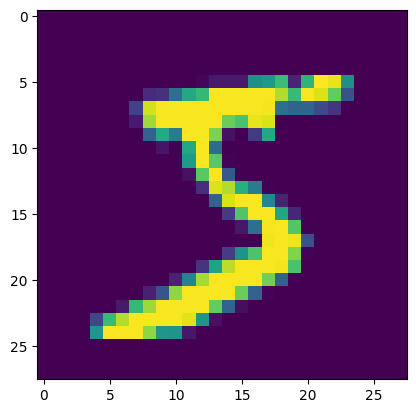

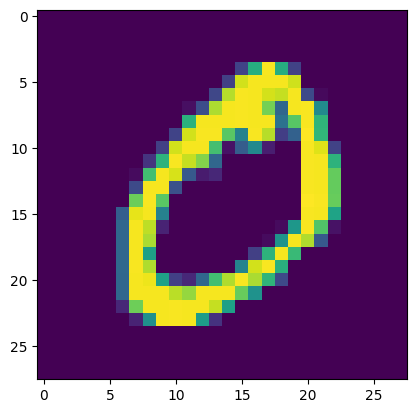

In [5]:
'''
DISPLAY THE DATA
'''
from matplotlib import pyplot as plt
show = 2
max_show = show
for i in full_train_set:
  current_image = i[0][0]
  plt.figure(max_show+1-show)
  plt.imshow(current_image)
  print(current_image.shape)
  show-=1
  if show==0:
    break

In [6]:
'''
USING TORCH DATA-LOADER
'''

train_loader = torch.utils.data.DataLoader(dataset=full_train_set,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=full_test_set,batch_size=batch_size,shuffle=False)

In [7]:
'''
BUILDING A TRIMMED ALEX-NET FOR MNIST CLASSIFICATION
'''

class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*13*13,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num)
        )

    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,256*13*13)
        x = self.classifier(x)
        return x

In [8]:
'''
ANALYZING TORCH MODEL SUMMARY
'''

model = AlexNet()

'''
ACCLERATED COMPUTING
'''

if torch.cuda.is_available():
  print('GPU is available!')
  model.cuda()

summary(model, (1, 28, 28))

GPU is available!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           6,656
              ReLU-2          [-1, 256, 28, 28]               0
         MaxPool2d-3          [-1, 256, 13, 13]               0
            Conv2d-4          [-1, 384, 13, 13]         885,120
              ReLU-5          [-1, 384, 13, 13]               0
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
              ReLU-7          [-1, 384, 13, 13]               0
            Conv2d-8          [-1, 256, 13, 13]         884,992
              ReLU-9          [-1, 256, 13, 13]               0
          Dropout-10                [-1, 43264]               0
           Linear-11                 [-1, 2048]      88,606,720
             ReLU-12                 [-1, 2048]               0
          Dropout-13                 [-1, 2048]               0
           Linear-14 

In [9]:
'''
MODEL TRAINING AND TESTING FUNCTIONS
'''

train_losses = []
test_losses = []

def train(model,optimizer,train_loader,epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.item()), end='')

def test(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()#size_average=False
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc / len(test_loader.dataset)))

    test_accuracy = (acc / len(test_loader.dataset))
    return test_accuracy

In [10]:
'''
INITIALIZE THE OPTIMIZER - LOSS FUNCTION
'''

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
'''
TRAIN AND TEST THE MODEL
'''

epochs = 2

for epoch in range(1, epochs+1):
    train(model,optimizer,train_loader,epoch)
    accuracy = test(model,test_loader)
    # print(f'----------------')
    # print(f'Epoch: {epoch+1}')
    # print(f'Accuracy: {accuracy}')

Epoch: 1 99%	     Loss: 0.062556
Test result: Average loss: 0.0996, Accuracy: 96.7600%

Epoch: 2 99%	     Loss: 0.002397
Test result: Average loss: 0.0523, Accuracy: 98.2300%

